In [1]:
import re
import swifter
import numpy as np
import pandas as pd
from typing import List, Union
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report

import tensorflow_text
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Dropout, Dense, GlobalAveragePooling1D, GRU, Bidirectional

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv('C:/Users/User/Desktop/FINAL-THESIS/training_set_en_dataset_aug.csv')
df_val = pd.read_csv('C:/Users/User/Desktop/FINAL-THESIS/val_set_en_dataset.csv')
df_test = pd.read_csv('C:/Users/User/Desktop/FINAL-THESIS/test_set_en_dataset.csv')

In [3]:
output_labels = ["abusive", "hateful", "offensive", "disrespectful", "fearful", "normal"]
n_labels = len(output_labels)

# Discard Empty Tweets if There Any.
def discard_empty_tweets(df):
    empty_tweet_filter = df["tweet"] != ""
    df = df[empty_tweet_filter]
    df = df.dropna()


discard_empty_tweets(df_train)
discard_empty_tweets(df_val)
discard_empty_tweets(df_test)

print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(5763, 8)
(562, 8)
(562, 8)


In [4]:
# Transform to int type.

def transform_to_int(df):
    df['abusive'] = df['abusive'].astype(np.int)
    df['hateful'] = df['hateful'].astype(np.int)
    df['offensive'] = df['offensive'].astype(np.int)
    df['disrespectful'] = df['disrespectful'].astype(np.int)
    df['fearful'] = df['fearful'].astype(np.int)
    df['normal'] = df['normal'].astype(np.int)

transform_to_int(df_train)
transform_to_int(df_val)
transform_to_int(df_test)

df_train['one_hot_labels'] = list(df_train[output_labels].values)

In [5]:
idx2label = dict(zip(range(15),output_labels))
labels = list(df_train.one_hot_labels.values)
idx2label

{0: 'abusive',
 1: 'hateful',
 2: 'offensive',
 3: 'disrespectful',
 4: 'fearful',
 5: 'normal'}

In [6]:
# Identifying indices of 'one_hot_labels' entries that only occur once
df_train = df_train.reset_index()
label_counts = df_train.one_hot_labels.astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(df_train[df_train.one_hot_labels.astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq_idxs)

df label indices with only one instance:  [1102, 1033, 123, 85]


In [7]:
train_sentences = df_train["tweet_cleaned"].values
test_sentences = df_test["tweet_cleaned"].values
val_sentences = df_val["tweet_cleaned"].values

train_y = df_train[output_labels].values
test_y = df_test[output_labels].values
val_y = df_val[output_labels].values

In [8]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", 
    trainable=True)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 1024].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 1024].

x = GlobalAveragePooling1D()(sequence_output)
x = Dropout(0.3)(x)
output = Dense(n_labels, activation='sigmoid', name='outputs')(x)

model = Model(inputs=text_input, outputs=output)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4, decay=1e-6), 
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.AUC(name='auc',multi_label=True, thresholds=[0, 0.5]),
                       tf.keras.metrics.TruePositives(name='TP'),
                       tf.keras.metrics.TrueNegatives(name='TN'),
                       tf.keras.metrics.FalsePositives(name='FP'),
                       tf.keras.metrics.FalseNegatives(name='FN')])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'input_word_ids': ( 0           input_1[0][0]                    
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'pooled_output': (N 109482241   keras_layer[0][0]                
                                                                 keras_layer[0][1]                
                                                                 keras_layer[0][2]                
______________________________________________________________________________________________

In [9]:
checkpointer = ModelCheckpoint(filepath='C:/Users/User/Desktop/FINAL-THESIS/BERT_weights_model_final.hdf5', 
                               verbose=1, save_best_only=True)

history = model.fit(train_sentences, train_y, epochs=5, 
                    batch_size=32, callbacks=[checkpointer],
                    validation_data=(val_sentences, val_y))

Epoch 1/5
181/181 [==============================] - 3781s 21s/step - loss: 0.5262 - accuracy: 0.4453 - precision: 0.7036 - recall: 0.4606 - auc: 0.6408 - TP: 5190.0000 - TN: 21124.0000 - FP: 2186.0000 - FN: 6078.0000 - val_loss: 0.4665 - val_accuracy: 0.5623 - val_precision: 0.7047 - val_recall: 0.4462 - val_auc: 0.4987 - val_TP: 377.0000 - val_TN: 2369.0000 - val_FP: 158.0000 - val_FN: 468.0000

Epoch 00001: val_loss improved from inf to 0.46651, saving model to C:/Users/User/Desktop/FINAL-THESIS\BERT_weights_model_final.hdf5
Epoch 2/5
181/181 [==============================] - 3923s 22s/step - loss: 0.4239 - accuracy: 0.4862 - precision: 0.8080 - recall: 0.6041 - auc: 0.7354 - TP: 6807.0000 - TN: 21692.0000 - FP: 1618.0000 - FN: 4461.0000 - val_loss: 0.4721 - val_accuracy: 0.5676 - val_precision: 0.7106 - val_recall: 0.4592 - val_auc: 0.5026 - val_TP: 388.0000 - val_TN: 2369.0000 - val_FP: 158.0000 - val_FN: 457.0000

Epoch 00002: val_loss did not improve from 0.46651
Epoch 3/5
181/

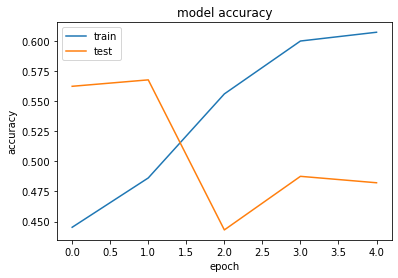

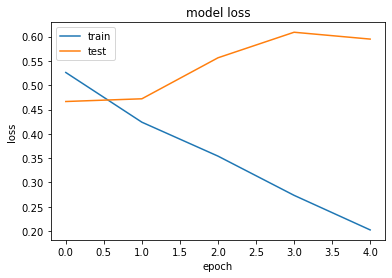

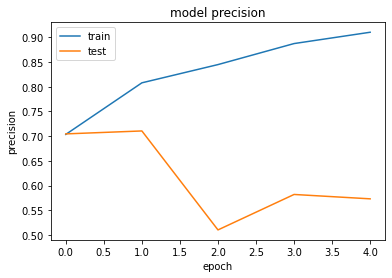

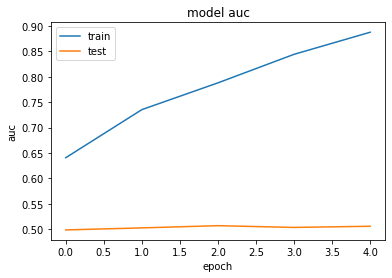

In [17]:
#Metrics Plots
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [11]:
model.load_weights(filepath='C:/Users/User/Desktop/FINAL-THESIS/BERT_weights_model_final.hdf5')

In [46]:
results = model.evaluate(val_sentences, val_y, batch_size=64)

9/9 [==============================] - 106s 12s/step - loss: 0.4665 - accuracy: 0.5623 - precision: 0.7047 - recall: 0.4462 - auc: 0.4987 - TP: 377.0000 - TN: 2369.0000 - FP: 158.0000 - FN: 468.0000


In [47]:
#####Initializing Metrics

F1_score = 2 * (results[2] * results[3])/(results[2] + results[3])
AUC=results[4]
TP=results[5]
TN=results[6]
FP=results[7]
FN=results[8]

###
#Printing Metrics Results
print("F1 SCORE: ", F1_score)
print("AUC SCORE: ", AUC)
print("True Positives: ", TP)
print("True Negatives: ", TN)
print("False Positives: ", FP)
print("False Negatives: ", FN)

F1 SCORE:  0.5463768067337199
AUC SCORE:  0.49865177273750305
True Positives:  377.0
True Negatives:  2369.0
False Positives:  158.0
False Negatives:  468.0


In [43]:

y_pred = model.predict(test_sentences)
y_pred = np.where(y_pred > 0.5, 1, 0)

y_true = test_y

In [44]:
print(test_sentences)
print(test_y)

['said yesterday pitch games mind nights row retarded'
 'bitch retarded hate' 'fuck mongy bin dipper'
 'yeah lucky watermelon uncultured twat' 'world shithole country ny'
 'daddy pain tits big cunt eating cum lezbo public wank wife bbc young masturbation canada nnurl'
 'sinead good reasons mussie raghead and mean best amp inter'
 'fucking retard man sad' 'sheck wes nigger' 'wanna spic'
 'come congleton name shame little twat headbutting kicking elderly men women toda'
 'people want stay shithole countries live in' 'okay faggot'
 'there is always handful twat waffles'
 'sometimes remember time whiny actual slur defending taylor swift fan tried claim cunt slur laugh'
 'know dyke like' 'people rather called spic hungry prosecuted'
 'can not possibly imagine stepping plate bench lmfao retarded chest would explode'
 'except ur massive twat cut said soju ruined whole vibe'
 'faggot ass dodgers'
 'fucking hate sonic drops coins valuable little cunt slow'
 'jew baiting retard shoots random syn

In [45]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=output_labels))

               precision    recall  f1-score   support

      abusive       0.00      0.00      0.00        60
      hateful       0.00      0.00      0.00       122
    offensive       0.73      0.95      0.83       407
disrespectful       0.00      0.00      0.00        72
      fearful       0.00      0.00      0.00        47
       normal       0.00      0.00      0.00       128

    micro avg       0.72      0.46      0.56       836
    macro avg       0.12      0.16      0.14       836
 weighted avg       0.36      0.46      0.40       836
  samples avg       0.69      0.59      0.61       836

